# Import Libraries

In [1]:
"""Basic connection example.
"""

import redis
from dotenv import load_dotenv
import os
import json
import csv

load_dotenv('.env')

USERNAME = os.getenv('REDIS_USERNAME')
PASSWORD = os.getenv('REDIS_PASSWORD')
db = redis.Redis(
    host='redis-16763.c304.europe-west1-2.gce.redns.redis-cloud.com',
    port=16763,
    decode_responses=True,
    username=USERNAME,
    password=PASSWORD,
)



In [2]:
def check_redis_status():
    if db.ping():
        print("✓ Connexion Redis établie")
        info = db.info('memory')
        print(f"Mémoire utilisée: {info['used_memory_human']}")
        print(f"Nombre de clés: {db.dbsize()}")
        return True
    else:
        print("✗ Échec de connexion Redis")
        return False

check_redis_status()

✓ Connexion Redis établie
Mémoire utilisée: 3.37M
Nombre de clés: 0


True

# Danger Zone ! Vider la base de données Redis

In [3]:
# db.flushall()
# print("Redis complètement vidé")
#
# # Ou pour supprimer seulement les index:
#
# patterns = ["tmdb:idx:*", "tmdb:genre*"]
# for pattern in patterns:
#     keys = db.keys(pattern)
#     if keys:
#         db.delete(*keys)
#         print(f"Supprimé {len(keys)} clés: {pattern}")

# Importer les data csv

In [4]:
def import_movies():
    count = db.scard("tmdb:movies") or 0

    if count > 0:
        print(f"Dataset déjà chargé: {count} films")
        return count

    print("Import des films en cours...")

    try:
        with open('datasets/tmdb_5000_movies.csv', 'r', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            batch_size = 100
            batch_count = 0

            pipe = db.pipeline(transaction=False)

            for idx, row in enumerate(reader, start=1):
                movie_id = row.get('id') or str(idx)
                key = f"tmdb:movie:{movie_id}"

                pipe.hset(key, mapping=row)
                pipe.sadd("tmdb:movies", key)

                if idx % batch_size == 0:
                    pipe.execute()
                    batch_count += 1
                    print(f"Importé {idx} films (lot {batch_count})")
                    pipe = db.pipeline(transaction=False)

            pipe.execute()

        final_count = db.scard("tmdb:movies")
        print(f"✓ Import terminé: {final_count} films")
        return final_count

    except FileNotFoundError:
        print("✗ Fichier CSV non trouvé: datasets/tmdb_5000_movies.csv")
        return 0
    except Exception as e:
        print(f"✗ Erreur import: {e}")
        return 0

movie_count = import_movies()
check_redis_status()

Import des films en cours...
Importé 100 films (lot 1)
Importé 200 films (lot 2)
Importé 300 films (lot 3)
Importé 400 films (lot 4)
Importé 500 films (lot 5)
Importé 600 films (lot 6)
Importé 700 films (lot 7)
Importé 800 films (lot 8)
Importé 900 films (lot 9)
Importé 1000 films (lot 10)
Importé 1100 films (lot 11)
Importé 1200 films (lot 12)
Importé 1300 films (lot 13)
Importé 1400 films (lot 14)
Importé 1500 films (lot 15)
Importé 1600 films (lot 16)
Importé 1700 films (lot 17)
Importé 1800 films (lot 18)
Importé 1900 films (lot 19)
Importé 2000 films (lot 20)
Importé 2100 films (lot 21)
Importé 2200 films (lot 22)
Importé 2300 films (lot 23)
Importé 2400 films (lot 24)
Importé 2500 films (lot 25)
Importé 2600 films (lot 26)
Importé 2700 films (lot 27)
Importé 2800 films (lot 28)
Importé 2900 films (lot 29)
Importé 3000 films (lot 30)
Importé 3100 films (lot 31)
Importé 3200 films (lot 32)
Importé 3300 films (lot 33)
Importé 3400 films (lot 34)
Importé 3500 films (lot 35)
Importé 3

True

# Construction des index

In [5]:
def to_float(s, default=0.0):
    try:
        return float(s) if s not in (None, "", "NaN") else default
    except:
        return default

def to_int(s, default=0):
    try:
        return int(float(s)) if s not in (None, "", "NaN") else default
    except:
        return default

def build_indexes():
    if db.exists("tmdb:idx:built"):
        print("Index déjà construits")
        return

    print("Construction des index...")
    movies = list(db.smembers("tmdb:movies"))
    batch_size = 50
    total_batches = (len(movies) - 1) // batch_size + 1

    genre_seen = set()

    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(movies))
        batch = movies[start_idx:end_idx]

        print(f"Traitement lot {batch_idx + 1}/{total_batches} ({len(batch)} films)")

        pipe = db.pipeline(transaction=False)

        for k in batch:
            try:
                fields = db.hmget(k, "popularity", "vote_average", "vote_count",
                                "revenue", "release_date", "title", "genres")
                pop_s, vote_avg_s, vote_cnt_s, revenue_s, release_date, title, genres = fields

                pop = to_float(pop_s, 0.0)
                vote_avg = to_float(vote_avg_s, 0.0)
                vote_cnt = to_int(vote_cnt_s, 0)
                revenue = to_float(revenue_s, 0.0)

                pipe.zadd("tmdb:idx:popularity", {k: pop})
                pipe.zadd("tmdb:idx:vote_average", {k: vote_avg})
                pipe.zadd("tmdb:idx:vote_count", {k: vote_cnt})
                pipe.zadd("tmdb:idx:revenue", {k: revenue})

                if release_date:
                    parts = release_date.split("-")
                    if len(parts) >= 3 and all(p.isdigit() for p in parts[:3]):
                        rd_score = int(parts[0]) * 10000 + int(parts[1]) * 100 + int(parts[2])
                        pipe.zadd("tmdb:idx:release_date", {k: rd_score})

                if title:
                    title_key = title.strip().lower()
                    pipe.hset("tmdb:idx:title_to_key", title_key, k)

                if genres:
                    try:
                        genre_list = json.loads(genres)
                        for genre_obj in genre_list or []:
                            if isinstance(genre_obj, dict):
                                name = genre_obj.get("name")
                                gid = genre_obj.get("id")

                                if name:
                                    slug = name.strip().lower().replace(" ", "_")
                                    pipe.zadd(f"tmdb:genre:pop:{slug}", {k: pop})
                                    genre_seen.add(slug)

                                if gid:
                                    try:
                                        gid_int = int(gid)
                                        pipe.zadd(f"tmdb:genreid:pop:{gid_int}", {k: pop})
                                    except:
                                        pass
                    except:
                        pass

            except Exception as e:
                print(f"Erreur sur film {k}: {e}")
                continue

        try:
            pipe.execute()
            print(f"✓ Lot {batch_idx + 1} traité avec succès")
        except Exception as e:
            print(f"✗ Erreur lot {batch_idx + 1}: {e}")
            return False

    db.set("tmdb:idx:built", 1)
    print(f"✓ Index construits avec succès")
    print(f"Genres indexés: {sorted(list(genre_seen))}")
    return True

if movie_count > 0:
    success = build_indexes()
    check_redis_status()
else:
    print("Impossible de construire les index: aucun film importé")

Construction des index...
Traitement lot 1/97 (50 films)
✓ Lot 1 traité avec succès
Traitement lot 2/97 (50 films)
✓ Lot 2 traité avec succès
Traitement lot 3/97 (50 films)
✓ Lot 3 traité avec succès
Traitement lot 4/97 (50 films)
✓ Lot 4 traité avec succès
Traitement lot 5/97 (50 films)
✓ Lot 5 traité avec succès
Traitement lot 6/97 (50 films)
✓ Lot 6 traité avec succès
Traitement lot 7/97 (50 films)
✓ Lot 7 traité avec succès
Traitement lot 8/97 (50 films)
✓ Lot 8 traité avec succès
Traitement lot 9/97 (50 films)
✓ Lot 9 traité avec succès
Traitement lot 10/97 (50 films)
✓ Lot 10 traité avec succès
Traitement lot 11/97 (50 films)
✓ Lot 11 traité avec succès
Traitement lot 12/97 (50 films)
✓ Lot 12 traité avec succès
Traitement lot 13/97 (50 films)
✓ Lot 13 traité avec succès
Traitement lot 14/97 (50 films)
✓ Lot 14 traité avec succès
Traitement lot 15/97 (50 films)
✓ Lot 15 traité avec succès
Traitement lot 16/97 (50 films)
✓ Lot 16 traité avec succès
Traitement lot 17/97 (50 films)


# Verification des index créés

In [6]:
def verify_indexes():
    print("=== Vérification des index ===")

    main_indexes = ["popularity", "vote_average", "vote_count", "revenue", "release_date"]
    for idx in main_indexes:
        key = f"tmdb:idx:{idx}"
        count = db.zcard(key)
        print(f"Index {idx}: {count} films")

    title_count = db.hlen("tmdb:idx:title_to_key")
    print(f"Index titre: {title_count} films")

    genre_keys = db.keys("tmdb:genre:pop:*")
    print(f"\nGenres par nom ({len(genre_keys)}):")
    for key in sorted(genre_keys)[:10]:
        genre = key.replace("tmdb:genre:pop:", "")
        count = db.zcard(key)
        print(f"  {genre}: {count} films")

    genreid_keys = db.keys("tmdb:genreid:pop:*")
    print(f"\nGenres par ID ({len(genreid_keys)}):")
    for key in sorted(genreid_keys, key=lambda x: int(x.split(":")[-1]))[:10]:
        genre_id = key.replace("tmdb:genreid:pop:", "")
        count = db.zcard(key)
        print(f"  ID {genre_id}: {count} films")

if db.exists("tmdb:idx:built"):
    verify_indexes()
else:
    print("Index non construits")

=== Vérification des index ===
Index popularity: 4803 films
Index vote_average: 4803 films
Index vote_count: 4803 films
Index revenue: 4803 films
Index release_date: 4802 films
Index titre: 4800 films

Genres par nom (20):
  action: 1154 films
  adventure: 790 films
  animation: 234 films
  comedy: 1722 films
  crime: 696 films
  documentary: 110 films
  drama: 2297 films
  family: 513 films
  fantasy: 424 films
  foreign: 34 films

Genres par ID (20):
  ID 12: 790 films
  ID 14: 424 films
  ID 16: 234 films
  ID 18: 2297 films
  ID 27: 519 films
  ID 28: 1154 films
  ID 35: 1722 films
  ID 36: 197 films
  ID 37: 82 films
  ID 53: 1274 films


# Fonctions utilitaires pour les requêtes

In [7]:
def search_by_genre(genre_input, page=1, page_size=10):
    """Recherche films par genre avec pagination"""
    val = (genre_input or "").strip()

    if val.isdigit():
        key_z = f"tmdb:genreid:pop:{int(val)}"
    else:
        slug = val.lower().replace(" ", "_")
        key_z = f"tmdb:genre:pop:{slug}"

    if not db.exists(key_z):
        # Recherche approximative
        genre_keys = db.keys("tmdb:genre:pop:*")
        matches = [k for k in genre_keys if val.lower() in k.lower()]

        if matches:
            key_z = matches[0]
            found_genre = key_z.replace("tmdb:genre:pop:", "")
            print(f"Genre '{genre_input}' non trouvé, utilisation de '{found_genre}'")
        else:
            available = [k.replace("tmdb:genre:pop:", "") for k in genre_keys[:5]]
            return f"Genre '{genre_input}' introuvable. Exemples: {available}"

    start = (page - 1) * page_size
    stop = start + page_size - 1
    members = db.zrevrange(key_z, start, stop)

    if not members:
        return f"Aucun résultat pour le genre '{genre_input}'"

    results = [f"Genre: {genre_input} — page {page}"]
    for i, k in enumerate(members, start=1 + start):
        title, pop = db.hmget(k, "title", "popularity")
        results.append(f"{i:2d}. {title} (popularité={pop})")

    return "\n".join(results)

def get_movie_details(title):
    """Récupère les détails d'un film par titre exact"""
    k = db.hget("tmdb:idx:title_to_key", title.strip().lower())
    if not k:
        return f"Film '{title}' introuvable"

    doc = db.hgetall(k)
    fields = ["title", "release_date", "runtime", "vote_average",
              "vote_count", "popularity", "revenue", "overview"]

    results = [f"Détails pour: {doc.get('title')}"]
    for f in fields:
        results.append(f"- {f}: {doc.get(f)}")

    return "\n".join(results)

# Requêtes pertinentes pour un site de films
Cette section regroupe uniquement des requêtes utiles dans un contexte d'application (liste "Populaires", "Meilleurs notés", "Nouveautés", navigation par genre, recherche, détail film). Chaque requête est indépendante, a un titre et une courte explication.

# Populaires — Top 20 par popularité
Liste des films les plus populaires, utile pour une page d'accueil ou une section "Tendances".

In [8]:
try:
    members = db.zrevrange("tmdb:idx:popularity", 0, 19)
    print("Populaires — Top 20:")
    for rank, k in enumerate(members, start=1):
        title, pop = db.hmget(k, "title", "popularity")
        print(f"{rank:2d}. {title} (popularité={pop})")
except Exception as e:
    print("Erreur (popularité):", e)


Populaires — Top 20:
 1. Minions (popularité=875.581305)
 2. Interstellar (popularité=724.247784)
 3. Deadpool (popularité=514.569956)
 4. Guardians of the Galaxy (popularité=481.098624)
 5. Mad Max: Fury Road (popularité=434.278564)
 6. Jurassic World (popularité=418.708552)
 7. Pirates of the Caribbean: The Curse of the Black Pearl (popularité=271.972889)
 8. Dawn of the Planet of the Apes (popularité=243.791743)
 9. The Hunger Games: Mockingjay - Part 1 (popularité=206.227151)
10. Big Hero 6 (popularité=203.73459)
11. Terminator Genisys (popularité=202.042635)
12. Captain America: Civil War (popularité=198.372395)
13. Whiplash (popularité=192.528841)
14. The Dark Knight (popularité=187.322927)
15. The Martian (popularité=167.93287)
16. Inception (popularité=167.58371)
17. Frozen (popularité=165.125366)
18. Batman v Superman: Dawn of Justice (popularité=155.790452)
19. Avatar (popularité=150.437577)
20. Fight Club (popularité=146.757391)


# Meilleurs notés — Top 10 avec seuil de votes
Classement par note moyenne, en imposant un minimum de votes pour éviter les biais.

In [9]:
min_votes = 1000
results = []
start = 0
batch = 200
while len(results) < 10:
    chunk = db.zrevrange("tmdb:idx:vote_average", start, start + batch - 1)
    if not chunk:
        break
    for k in chunk:
        title, vote, vcnt = db.hmget(k, "title", "vote_average", "vote_count")
        try:
            if int(float(vcnt or 0)) >= min_votes:
                results.append((title, vote, vcnt))
                if len(results) >= 10:
                    break
        except Exception:
            continue
    start += batch

print(f"Meilleurs notés (≥ {min_votes} votes):")
for i, (title, vote, vcnt) in enumerate(results, start=1):
    print(f"{i:2d}. {title} — note={vote}, votes={vcnt}")


Meilleurs notés (≥ 1000 votes):
 1. The Shawshank Redemption — note=8.5, votes=8205
 2. The Godfather — note=8.4, votes=5893
 3. Pulp Fiction — note=8.3, votes=8428
 4. Fight Club — note=8.3, votes=9413
 5. Schindler's List — note=8.3, votes=4329
 6. Whiplash — note=8.3, votes=4254
 7. The Godfather: Part II — note=8.3, votes=3338
 8. Spirited Away — note=8.3, votes=3840
 9. GoodFellas — note=8.2, votes=3128
10. American History X — note=8.2, votes=3016


# Nouveautés — Sorties récentes sur N années
Section "Nouveautés" basée sur la date de sortie la plus récente.

In [10]:
from datetime import date
years = 10
current_year = date.today().year
min_score = (current_year - years) * 10000
members = db.zrevrangebyscore("tmdb:idx:release_date", "+inf", min_score, start=0, num=20)
print(f"Nouveautés (sur ~{years} ans):")
for i, k in enumerate(members, start=1):
    title, rdate = db.hmget(k, "title", "release_date")
    print(f"{i:2d}. {title} — sortie le {rdate}")


Nouveautés (sur ~10 ans):
 1. Growing Up Smith — sortie le 2017-02-03
 2. Two Lovers and a Bear — sortie le 2016-10-02
 3. Mr. Church — sortie le 2016-09-16
 4. Kicks — sortie le 2016-09-09
 5. The Birth of a Nation — sortie le 2016-09-09
 6. Antibirth — sortie le 2016-09-02
 7. Hands of Stone — sortie le 2016-08-26
 8. Ben-Hur — sortie le 2016-08-17
 9. Pete's Dragon — sortie le 2016-08-10
10. Suicide Squad — sortie le 2016-08-02
11. Indignation — sortie le 2016-07-29
12. Shin Godzilla — sortie le 2016-07-29
13. Bad Moms — sortie le 2016-07-28
14. Operation Chromite — sortie le 2016-07-27
15. Nerve — sortie le 2016-07-27
16. Jason Bourne — sortie le 2016-07-27
17. Fight Valley — sortie le 2016-07-22
18. Lights Out — sortie le 2016-07-21
19. Ghostbusters — sortie le 2016-07-14
20. Kickboxer: Vengeance — sortie le 2016-07-14


# Box-office — Top 10 par recettes
Classement par chiffre d'affaires (revenue), utile pour une section "Box-office".

In [11]:
members = db.zrevrange("tmdb:idx:revenue", 0, 9)
print("Box-office — Top 10:")
for i, k in enumerate(members, start=1):
    title, revenue = db.hmget(k, "title", "revenue")
    try:
        revenue = float(revenue or 0)
    except Exception:
        revenue = 0
    print(f"{i:2d}. {title} — revenue=${int(revenue):,}")


Box-office — Top 10:
 1. Avatar — revenue=$2,787,965,087
 2. Titanic — revenue=$1,845,034,188
 3. The Avengers — revenue=$1,519,557,910
 4. Jurassic World — revenue=$1,513,528,810
 5. Furious 7 — revenue=$1,506,249,360
 6. Avengers: Age of Ultron — revenue=$1,405,403,694
 7. Frozen — revenue=$1,274,219,009
 8. Iron Man 3 — revenue=$1,215,439,994
 9. Minions — revenue=$1,156,730,962
10. Captain America: Civil War — revenue=$1,153,304,495


# Parcourir par genre — Pagination et tri popularité
Navigation par genre avec paramètres de page et taille de page. Vous pouvez fournir un nom de genre (ex: "Drama")

In [12]:
genre_input = "Crime"
page = 1
page_size = 10
val = (genre_input or "").strip()
if val.isdigit():
    key_z = f"tmdb:genreid:pop:{int(val)}"
else:
    slug = val.lower().replace(" ", "_")
    key_z = f"tmdb:genre:pop:{slug}"
start = (page - 1) * page_size
stop = start + page_size - 1
members = db.zrevrange(key_z, start, stop)
if not members:
    print(f"Aucun résultat pour le genre '{genre_input}'.")
else:
    print(f"Genre: {genre_input} — page {page}")
    for i, k in enumerate(members, start=1 + start):
        title, pop = db.hmget(k, "title", "popularity")
        print(f"{i:2d}. {title} (popularité={pop})")


Genre: Crime — page 1
 1. The Dark Knight (popularité=187.322927)
 2. The Godfather (popularité=143.659698)
 3. The Shawshank Redemption (popularité=136.747729)
 4. Pulp Fiction (popularité=121.463076)
 5. Chappie (popularité=116.700319)
 6. Batman Begins (popularité=115.040024)
 7. The Dark Knight Rises (popularité=112.31295)
 8. Quantum of Solace (popularité=107.928811)
 9. Spectre (popularité=107.376788)
10. The Godfather: Part II (popularité=105.792936)


# Recherche — Mot-clé dans le titre et le synopsis
Recherche simple côté client sans RediSearch, utile comme fallback pour un champ de recherche.

In [13]:
def search_optimized_v1(keyword, max_results=10):
    needle = (keyword or "").lower().strip()
    if not needle:
        return []

    keys = list(db.smembers("tmdb:movies"))
    results = []
    batch_size = 100

    for i in range(0, len(keys), batch_size):
        batch = keys[i:i+batch_size]
        pipe = db.pipeline(transaction=False)

        for k in batch:
            pipe.hmget(k, "title", "overview")

        batch_results = pipe.execute()

        for j, (title, overview) in enumerate(batch_results):
            title_lower = (title or "").lower()
            overview_lower = (overview or "").lower()

            if needle in title_lower or needle in overview_lower:
                results.append(title or "(sans titre)")
                if len(results) >= max_results:
                    return results

    return results

keyword = "romance"
results = search_optimized_v1(keyword)
if results:
    print(f"Résultats pour '{keyword}' (max 10):")
    for t in results:
        print(f"- {t}")
else:
    print(f"Aucun film trouvé pour '{keyword}'.")

Résultats pour 'romance' (max 10):
- Superman III
- Robin Hood
- Hav Plenty
- Admission
- Can't Hardly Wait
- Cloud Atlas
- Code 46
- Shanghai Calling
- The Valley of Decision
- Becoming Jane


# Détail — Informations d'un film par titre exact
Récupère les informations principales d'un film à partir de son titre exact via un index titre→clé.

In [14]:
search_title = "King Kong"
k = db.hget("tmdb:idx:title_to_key", (search_title or "").strip().lower())
if not k:
    print("Titre introuvable. Vérifiez l'orthographe exacte.")
else:
    doc = db.hgetall(k)
    fields = [
        "title", "release_date", "runtime", "vote_average", "vote_count",
        "popularity", "revenue", "genres", "overview"
    ]
    print(f"Détails pour: {doc.get('title')}")
    for f in fields:
        print(f"- {f}: {doc.get(f)}")


Détails pour: King Kong
- title: King Kong
- release_date: 2005-12-14
- runtime: 187
- vote_average: 6.6
- vote_count: 2337
- popularity: 61.22601
- revenue: 550000000
- genres: [{"id": 12, "name": "Adventure"}, {"id": 18, "name": "Drama"}, {"id": 28, "name": "Action"}]
- overview: In 1933 New York, an overly ambitious movie producer coerces his cast and hired ship crew to travel to mysterious Skull Island, where they encounter Kong, a giant ape who is immediately smitten with the leading lady.


In [25]:
def search_by_title_keyword(keyword, max_results=10):
    """Recherche films par mot-clé dans le titre uniquement"""
    needle = (keyword or "").lower().strip()
    if not needle:
        return []

    results = []
    movies = list(db.smembers("tmdb:movies"))
    batch_size = 200

    for i in range(0, len(movies), batch_size):
        batch = movies[i:i+batch_size]
        pipe = db.pipeline(transaction=False)

        for k in batch:
            pipe.hget(k, "title")

        titles = pipe.execute()

        for title in titles:
            if title and needle in title.lower():
                results.append(title)
                if len(results) >= max_results:
                    return results

    return results

def search_by_title_advanced(keyword, max_results=10):
    """Recherche avancée par titre avec scoring"""
    needle = (keyword or "").lower().strip()
    if not needle:
        return []

    movies = list(db.smembers("tmdb:movies"))
    matches = []
    batch_size = 200

    for i in range(0, len(movies), batch_size):
        batch = movies[i:i+batch_size]
        pipe = db.pipeline(transaction=False)

        for k in batch:
            pipe.hmget(k, "title", "popularity")

        batch_data = pipe.execute()

        for title, popularity in batch_data:
            if title:
                title_lower = title.lower()
                if needle in title_lower:
                    score = 0
                    pop = float(popularity or 0)

                    if title_lower.startswith(needle):
                        score += 1000
                    elif title_lower.startswith(needle + " "):
                        score += 800
                    elif " " + needle in title_lower:
                        score += 500
                    else:
                        score += 100

                    score += pop * 0.1

                    matches.append((score, title))

    matches.sort(key=lambda x: x[0], reverse=True)

    return [title for score, title in matches[:max_results]]

def build_title_index():
    """Construit un index des mots présents dans les titres"""
    if db.exists("tmdb:idx:title_words_built"):
        print("Index des mots de titres déjà construit")
        return

    print("Construction de l'index des mots de titres...")
    movies = list(db.smembers("tmdb:movies"))
    batch_size = 100

    for i in range(0, len(movies), batch_size):
        batch = movies[i:i+batch_size]
        pipe = db.pipeline(transaction=False)

        print(f"Indexation titres lot {i//batch_size + 1}/{(len(movies)-1)//batch_size + 1}")

        title_pipe = db.pipeline(transaction=False)
        for k in batch:
            title_pipe.hget(k, "title")
        titles = title_pipe.execute()

        for k, title in zip(batch, titles):
            if title:
                words = title.lower().replace(":", "").replace("-", " ").replace("'", "").split()
                stop_words = {'the', 'a', 'an', 'and', 'or', 'of', 'in', 'on', 'at', 'to', 'for', 'with', 'by'}

                for word in words:
                    clean_word = ''.join(c for c in word if c.isalnum())
                    if len(clean_word) >= 2 and clean_word not in stop_words:
                        pipe.sadd(f"tmdb:title_word:{clean_word}", k)

        pipe.execute()

    db.set("tmdb:idx:title_words_built", 1)
    print("✓ Index des mots de titres construit")

def search_by_title_indexed(keyword, max_results=10):
    """Recherche par titre avec index des mots"""
    needle = (keyword or "").lower().strip()
    if not needle:
        return []

    clean_needle = ''.join(c for c in needle if c.isalnum())

    movie_keys = db.smembers(f"tmdb:title_word:{clean_needle}")

    if movie_keys:
        # Récupérer les titres et popularités
        pipe = db.pipeline(transaction=False)
        for k in movie_keys:
            pipe.hmget(k, "title", "popularity")

        data = pipe.execute()

        movies_with_pop = []
        for title, popularity in data:
            if title:
                pop = float(popularity or 0)
                movies_with_pop.append((pop, title))

        movies_with_pop.sort(key=lambda x: x[0], reverse=True)
        return [title for pop, title in movies_with_pop[:max_results]]

    word_keys = db.keys("tmdb:title_word:*")
    matches = set()

    for word_key in word_keys:
        word = word_key.replace("tmdb:title_word:", "")
        if clean_needle in word:
            movie_keys = db.smembers(word_key)
            matches.update(movie_keys)
            if len(matches) >= max_results * 3:
                break

    if matches:
        pipe = db.pipeline(transaction=False)
        for k in list(matches)[:max_results*2]:
            pipe.hmget(k, "title", "popularity")

        data = pipe.execute()
        movies_with_pop = []

        for title, popularity in data:
            if title and needle in title.lower():
                pop = float(popularity or 0)
                movies_with_pop.append((pop, title))

        movies_with_pop.sort(key=lambda x: x[0], reverse=True)
        return [title for pop, title in movies_with_pop[:max_results]]

    return []

build_title_index()

def search_titles(keyword, max_results=10):
    if db.exists("tmdb:idx:title_words_built"):
        return search_by_title_indexed(keyword, max_results)
    else:
        return search_by_title_advanced(keyword, max_results)

# search_titles("Good")
# search_by_title_advanced("War")
# search_by_title_indexed("War", 5)

Index des mots de titres déjà construit


['Captain America: Civil War',
 'World War Z',
 "The Huntsman: Winter's War",
 'War of the Worlds',
 'This Means War']

# Visualisations — Imports et configuration

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Le backend inline est géré par Jupyter; plt.show() est appelé à la fin de chaque tracé.

# Petite fonction utilitaire pour itérer les films par lots et récupérer des champs spécifiques

def iter_movies_fields(field_names, batch_size=200):
    keys = list(db.smembers("tmdb:movies"))
    total = len(keys)
    for start in range(0, total, batch_size):
        batch = keys[start:start+batch_size]
        pipe = db.pipeline(transaction=False)
        for k in batch:
            pipe.hmget(k, *field_names)
        data = pipe.execute()
        for k, vals in zip(batch, data):
            yield k, vals


# Schéma 1 — Répartition des genres (Top 12)
Visualisation utile pour la navigation par catégories et pour comprendre l'offre de contenus.

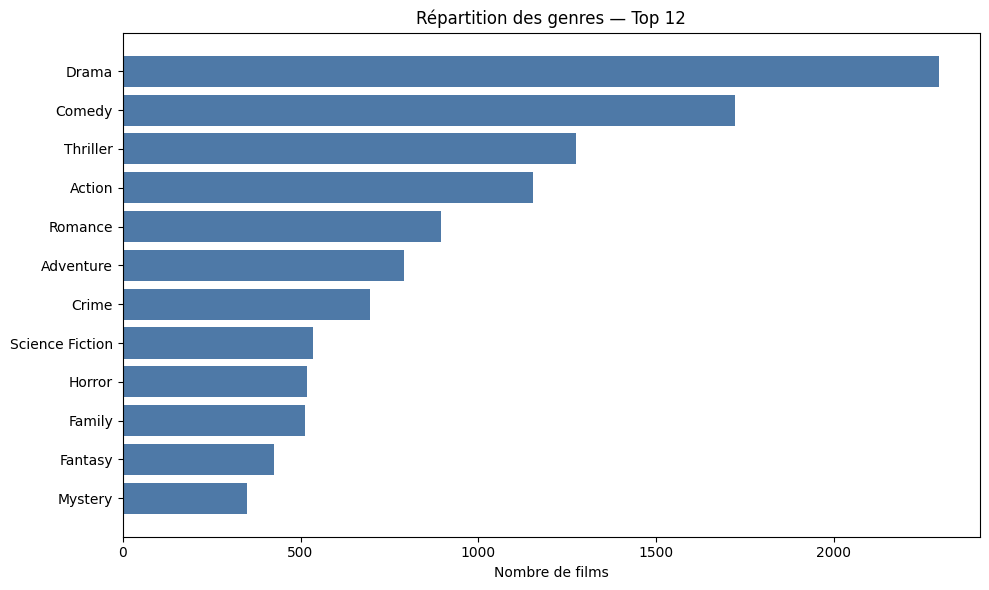

In [27]:
from collections import Counter

genre_counts = Counter()
for k, (genres_json,) in iter_movies_fields(["genres"], batch_size=300):
    if not genres_json:
        continue
    try:
        arr = json.loads(genres_json)
        for g in arr or []:
            if isinstance(g, dict):
                name = g.get("name")
                if name:
                    genre_counts[name] += 1
    except Exception:
        continue

if genre_counts:
    top = genre_counts.most_common(12)
    labels = [g for g, _ in top]
    values = [c for _, c in top]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(labels[::-1], values[::-1], color="#4e79a7")
    plt.title("Répartition des genres — Top 12")
    plt.xlabel("Nombre de films")
    plt.tight_layout()
    plt.show()
else:
    print("Aucun genre à afficher")


# Schéma 2 — Chronologie des sorties (histogramme par année)
Utile pour une section "Nouveautés" ou pour filtrer par période.

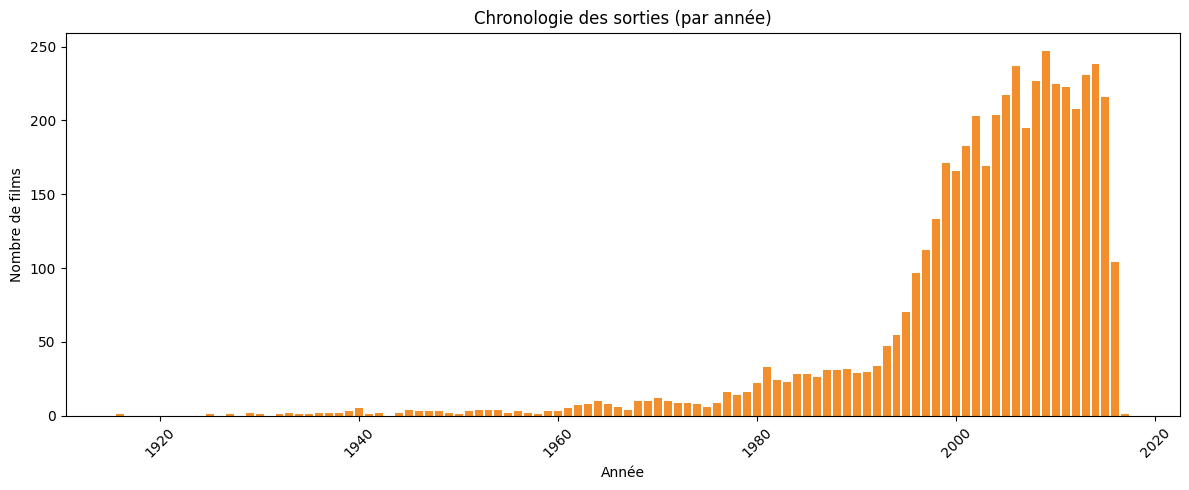

In [28]:
from datetime import date

years = []
for k, (release_date,) in iter_movies_fields(["release_date"], batch_size=300):
    if not release_date:
        continue
    try:
        y = int(release_date.split("-")[0])
        if 1900 <= y <= date.today().year:
            years.append(y)
    except Exception:
        continue

if years:
    year_counts = Counter(years)
    years_sorted = sorted(year_counts)
    counts = [year_counts[y] for y in years_sorted]

    plt.figure(figsize=(12, 5))
    plt.bar(years_sorted, counts, color="#f28e2b")
    plt.title("Chronologie des sorties (par année)")
    plt.xlabel("Année")
    plt.ylabel("Nombre de films")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Aucune date de sortie disponible")


# Schéma 3 — Meilleurs notés (Top 10, ≥ 1000 votes)
Utile pour une page "Meilleurs films" avec un seuil de confiance sur le nombre de votes.

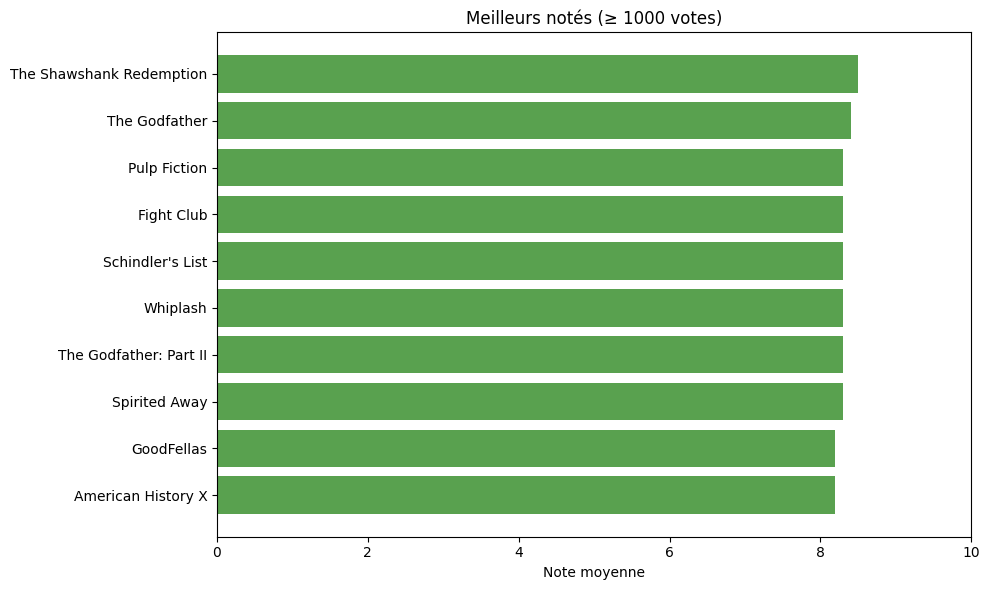

In [29]:
min_votes = 1000
results = []
start = 0
batch = 200
while len(results) < 10:
    chunk = db.zrevrange("tmdb:idx:vote_average", start, start + batch - 1)
    if not chunk:
        break
    for k in chunk:
        title, vote, vcnt = db.hmget(k, "title", "vote_average", "vote_count")
        try:
            va = float(vote or 0)
            vc = int(float(vcnt or 0))
            if vc >= min_votes:
                results.append((title, va, vc))
                if len(results) >= 10:
                    break
        except Exception:
            continue
    start += batch

if results:
    titles = [t for t, _, _ in results][::-1]
    votes = [v for _, v, _ in results][::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(titles, votes, color="#59a14f")
    plt.xlabel("Note moyenne")
    plt.title(f"Meilleurs notés (≥ {min_votes} votes)")
    plt.xlim(0, 10)
    plt.tight_layout()
    plt.show()
else:
    print("Aucun résultat pour les meilleurs notés avec le seuil demandé")


# Schéma 4 — Box-office (Top 10 par recettes)
Pertinent pour une section "Box-office" ou "Blockbusters".

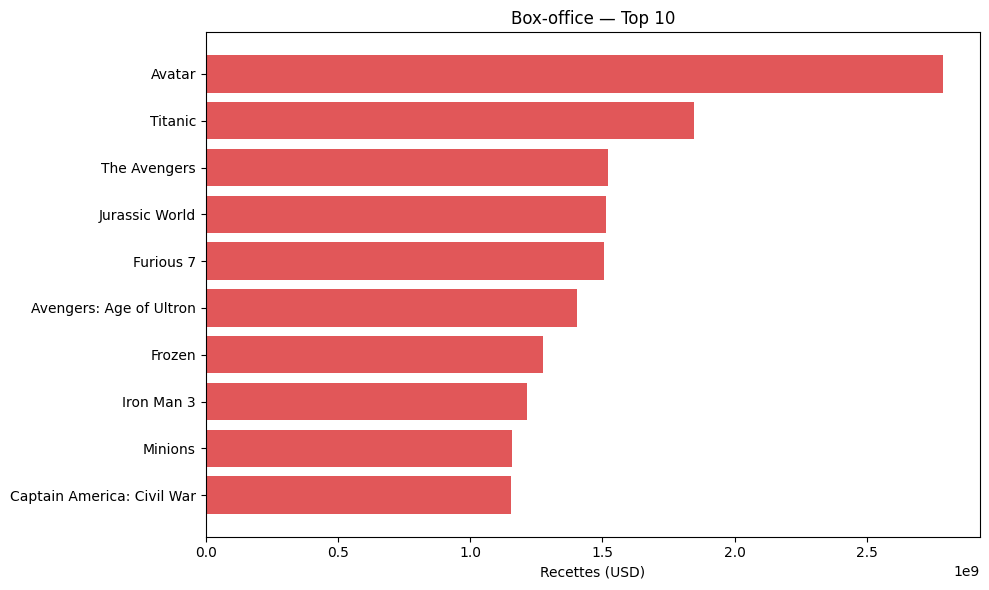

In [30]:
members = db.zrevrange("tmdb:idx:revenue", 0, 9)
boxoffice = []
for k in members:
    title, revenue = db.hmget(k, "title", "revenue")
    try:
        boxoffice.append((title, float(revenue or 0)))
    except Exception:
        continue

if boxoffice:
    titles = [t for t, _ in boxoffice][::-1]
    revenues = [r for _, r in boxoffice][::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(titles, revenues, color="#e15759")
    plt.xlabel("Recettes (USD)")
    plt.title("Box-office — Top 10")
    plt.tight_layout()
    plt.show()
else:
    print("Pas de données de box-office disponibles")


# Schéma 5 — Distribution des durées
Utile pour calibrer des filtres (ex: < 90 min, 90–120, > 120).

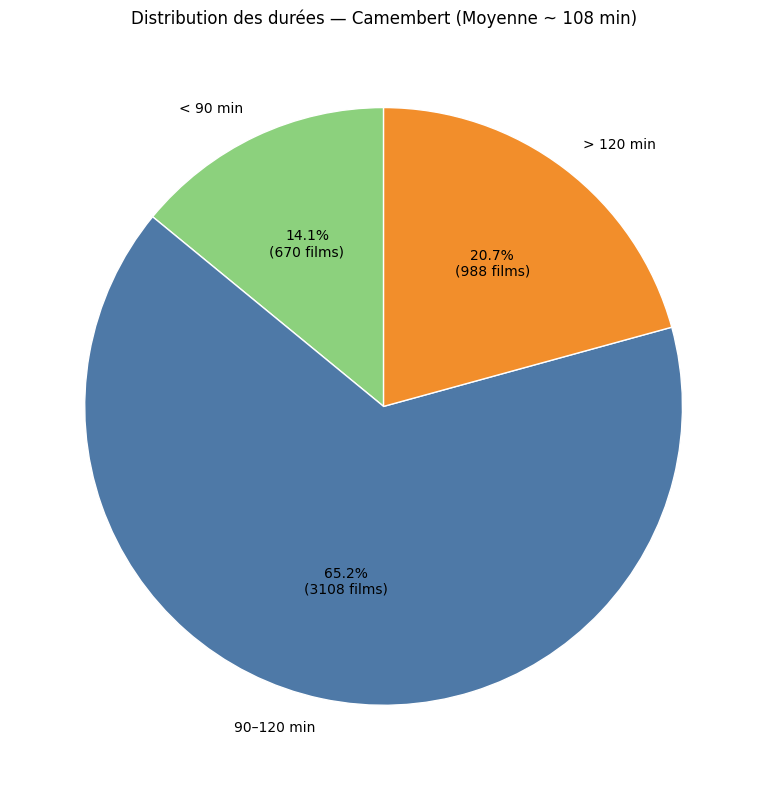

In [33]:
runtimes = []
for k, (rt,) in iter_movies_fields(["runtime"], batch_size=300):
    try:
        v = float(rt or 0)
        if v > 0:
            runtimes.append(v)
    except Exception:
        continue

if runtimes:
    arr = np.array(runtimes)
    mean_v = float(np.mean(arr))

    count_lt_90 = int((arr < 90).sum())
    count_90_120 = int(((arr >= 90) & (arr <= 120)).sum())
    count_gt_120 = int((arr > 120).sum())

    labels = ["< 90 min", "90–120 min", "> 120 min"]
    sizes = [count_lt_90, count_90_120, count_gt_120]

    labels_f = [l for l, s in zip(labels, sizes) if s > 0]
    sizes_f = [s for s in sizes if s > 0]
    colors = ["#8cd17d", "#4e79a7", "#f28e2b"]
    colors_f = colors[:len(sizes_f)]

    plt.figure(figsize=(8, 8))
    plt.pie(
        sizes_f,
        labels=labels_f,
        autopct=lambda p: f"{p:.1f}%\n({int(round(p/100*sum(sizes_f)))} films)",
        startangle=90,
        colors=colors_f,
        wedgeprops={"edgecolor": "white"},
    )
    plt.title(f"Distribution des durées — Camembert (Moyenne ~ {mean_v:.0f} min)")
    plt.tight_layout()
    plt.show()
else:
    print("Aucune durée disponible")


# Schéma 6 — Note moyenne vs nombre de votes (scatter)
Aide à comprendre la relation entre popularité et qualité perçue.

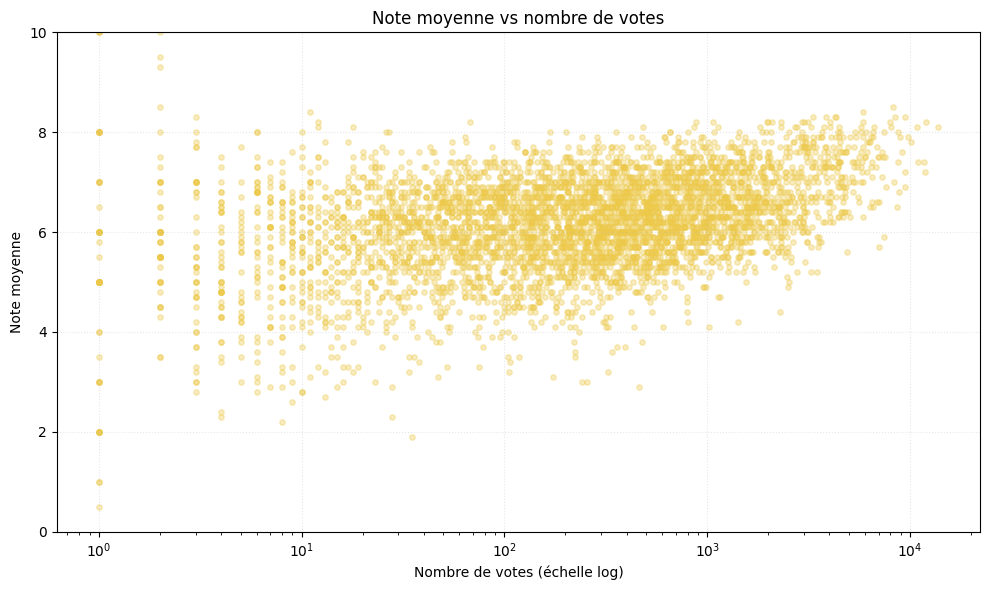

In [32]:
points = []
for k, (va, vc) in iter_movies_fields(["vote_average", "vote_count"], batch_size=300):
    try:
        y = float(va or 0)
        x = int(float(vc or 0))
        if x > 0 and y > 0:
            points.append((x, y))
    except Exception:
        continue

if points:
    xs, ys = zip(*points)
    plt.figure(figsize=(10, 6))
    plt.scatter(xs, ys, s=15, alpha=0.35, color="#edc949")
    plt.xscale("log")
    plt.ylim(0, 10)
    plt.xlabel("Nombre de votes (échelle log)")
    plt.ylabel("Note moyenne")
    plt.title("Note moyenne vs nombre de votes")
    plt.grid(True, linestyle=":", alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("Pas de données suffisantes pour le nuage de points")
